## 卷积层

Let's load two sample images, rescale their pixel values to 0-1, and center crop them to small 70×120 images:
加载两张图片，把像素缩放至0-1

In [1]:
from sklearn.datasets import load_sample_images
import tensorflow as tf

images = load_sample_images()["images"]
images = tf.keras.layers.CenterCrop(height=70, width=120)(images)
images = tf.keras.layers.Rescaling(scale=1 / 255)(images)

2023-11-16 17:12:39.903649: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-16 17:12:40.293400: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-16 17:12:43.319003: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
images.shape

TensorShape([2, 70, 120, 3])

As you can see, randomly generated filters typically act like edge detectors, which is great since that's a useful tool in image processing, and that's the type of filters that a convolutional layer typically starts with. Then, during training, it gradually learns improved filters to recognize useful patterns for the task.

Now let's use zero-padding:

In [3]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7)
fmaps = conv_layer(images)

In [4]:
fmaps.shape

TensorShape([2, 64, 114, 32])

In [7]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

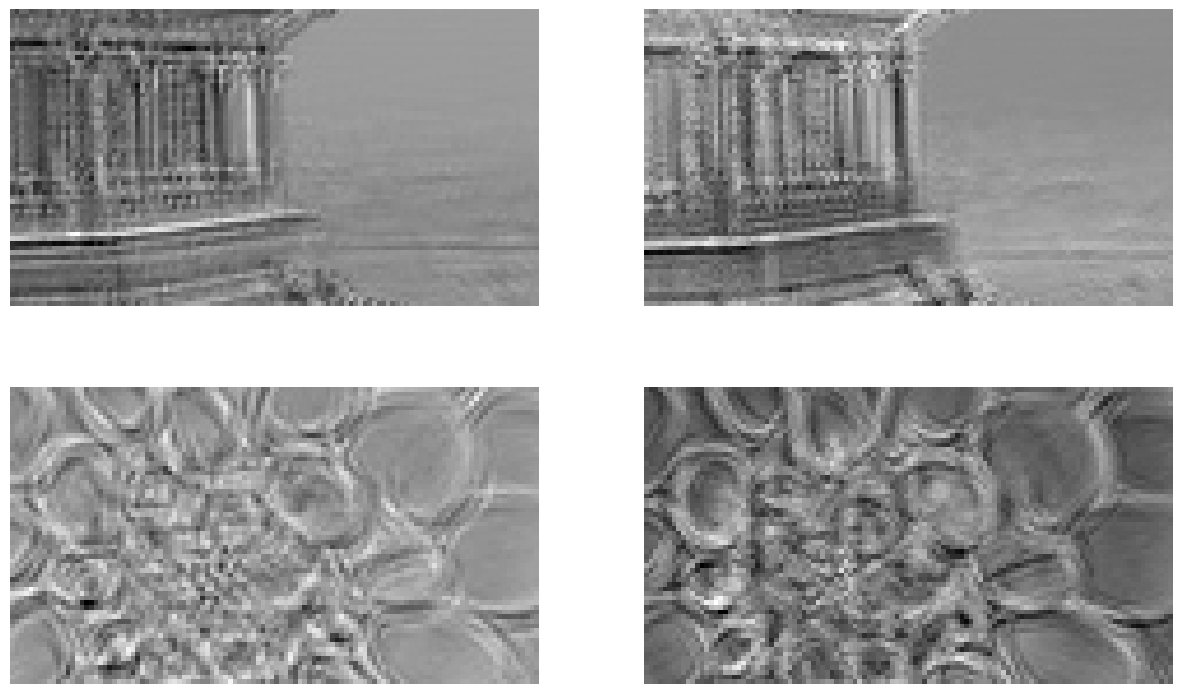

In [8]:

# extra code – displays the two output feature maps for each image

plt.figure(figsize=(15, 9))
for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()

In [9]:
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7,
                                    padding="same")
fmaps = conv_layer(images)

In [10]:
fmaps.shape

TensorShape([2, 70, 120, 32])

In [11]:
# extra code – shows that the output shape when we set strides=2
# 步长设置为 2，则 output 变小了一倍
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7, padding="same",
                                    strides=2)
fmaps = conv_layer(images)
fmaps.shape

TensorShape([2, 35, 60, 32])

In [12]:
# extra code – this utility function can be useful to compute the size of the
#              feature maps output by a convolutional layer. It also returns
#              the number of ignored rows or columns if padding="valid", or the
#              number of zero-padded rows or columns if padding="same"."""

import numpy as np

def conv_output_size(input_size, kernel_size, strides=1, padding="valid"):
    if padding=="valid":
        z = input_size - kernel_size + strides
        output_size = z // strides
        num_ignored = z % strides
        return output_size, num_ignored
    else:
        output_size = (input_size - 1) // strides + 1
        num_padded = (output_size - 1) * strides + kernel_size - input_size
        return output_size, num_padded

conv_output_size(np.array([70, 120]), kernel_size=7, strides=2, padding="same")

(array([35, 60]), array([5, 5]))

In [13]:
kernels, biases = conv_layer.get_weights()
kernels.shape

(7, 7, 3, 32)

In [14]:
biases.shape

(32,)

In [15]:
# extra code – shows how to use the tf.nn.conv2d() operation

tf.random.set_seed(42)
filters = tf.random.normal([7, 7, 3, 2])
biases = tf.zeros([2])
fmaps = tf.nn.conv2d(images, filters, strides=1, padding="SAME") + biases

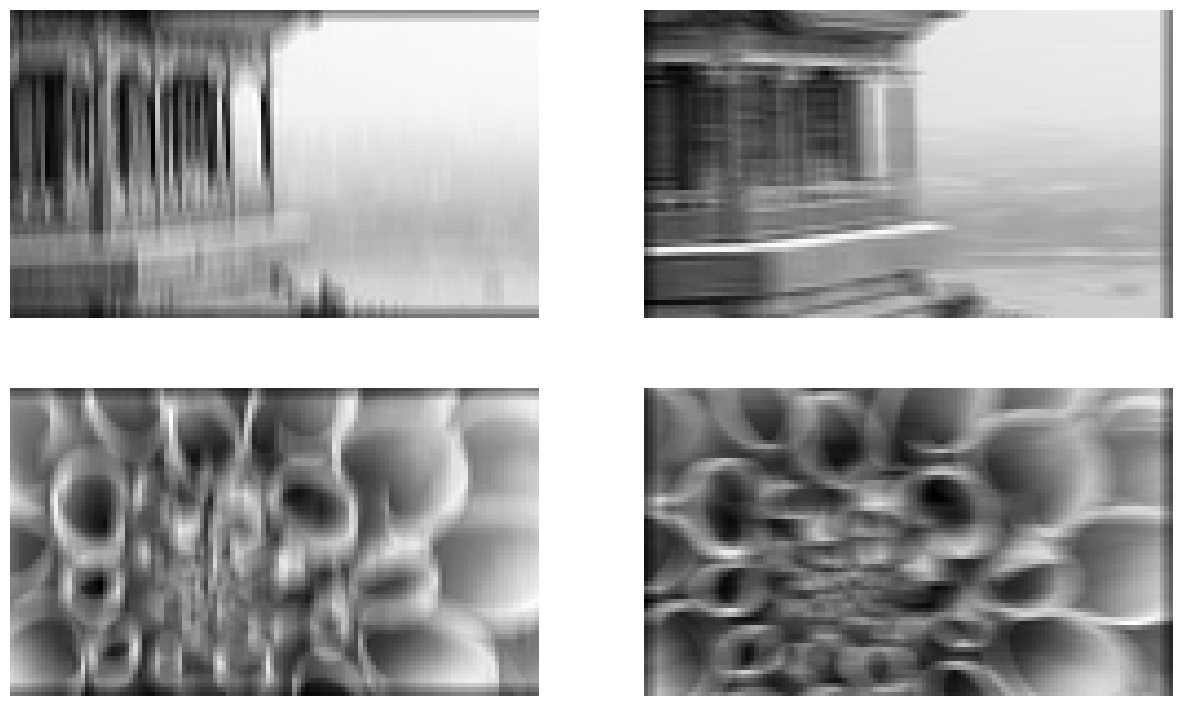

In [16]:
# extra code – shows how to manually create two filters to get images similar
#              to those in Figure 14–5.

plt.figure(figsize=(15, 9))
filters = np.zeros([7, 7, 3, 2])
filters[:, 3, :, 0] = 1
filters[3, :, :, 1] = 1
fmaps = tf.nn.conv2d(images, filters, strides=1, padding="SAME") + biases

for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()

Notice the dark lines at the top and bottom of the two images on the left, and on the left and right of the two images on the right? Can you guess what these are? Why were they not present in the previous figure?

You guessed it! These are artifacts due to the fact that we used zero padding in this case, while we did not use zero padding to create the feature maps in the previous figure. Because of zero padding, the two feature maps based on the vertical line filter (i.e., the two left images) could not fully activate near the top and bottom of the images. Similarly, the two feature maps based on the horizontal line filter (i.e., the two right images) could not fully activate near the left and right of the images.

## 池化层

### 使用 keras 实现池化层

Max pooling 最大池化层

In [17]:
max_pool = tf.keras.layers.MaxPool2D(pool_size=2)

In [18]:
output = max_pool(images)

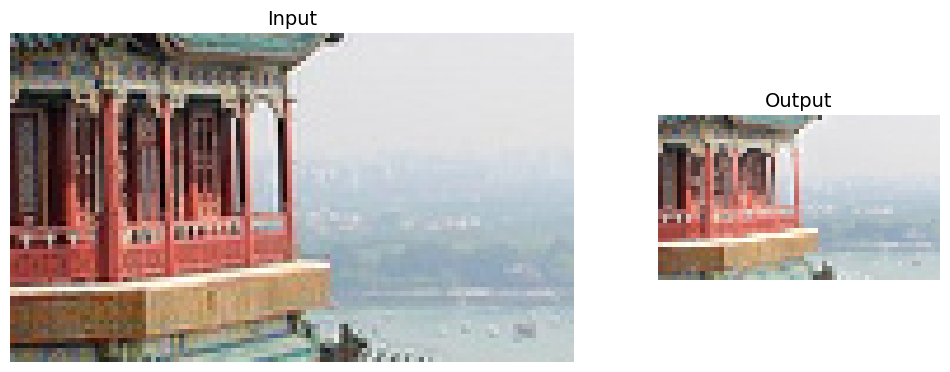

In [19]:
# extra code – this cells shows what max pooling with stride = 2 looks like

import matplotlib as mpl

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input")
ax1.imshow(images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output")
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

Depth-wise pooling

In [20]:
# 如何使用 max_pool() op
np.random.seed(42)
fmaps = np.random.rand(2, 70, 120, 60)
with tf.device("/cpu:0"):
    output = tf.nn.max_pool(fmaps, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3), padding="VALID")

output.shape

TensorShape([2, 70, 120, 20])

In [21]:
class DepthPool(tf.keras.layers.Layer):
    def __init__(self, pool_size=2, **kwargs):
        super().__init__(**kwargs)
        self.pool_size = pool_size
    
    def call(self, inputs):
        shape = tf.shape(inputs)  # shape[-1] is the number of channels
        groups = shape[-1] // self.pool_size  # number of channel groups
        new_shape = tf.concat([shape[:-1], [groups, self.pool_size]], axis=0)
        return tf.reduce_max(tf.reshape(inputs, new_shape), axis=-1)

In [22]:
# 查看自定层的结果是否和 max_pool() 一致
np.allclose(DepthPool(pool_size=3)(fmaps), output)

True

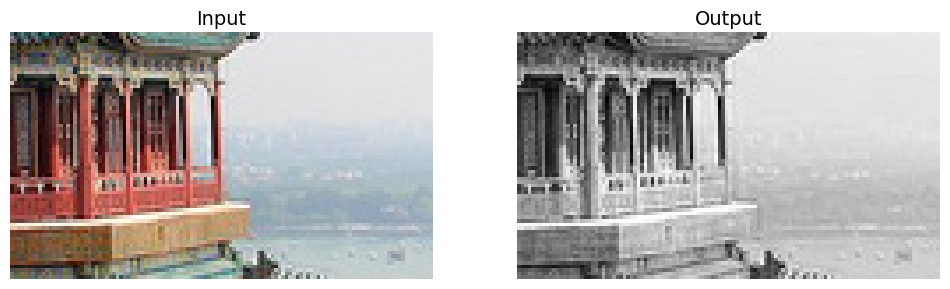

In [23]:
depth_output = DepthPool(pool_size=3)(images)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input")
plt.imshow(images[0])  # plot the 1st image
plt.axis("off")
plt.subplot(1, 2, 2)
plt.title("Output")
plt.imshow(depth_output[0, ..., 0], cmap="gray")  # plot 1st image's output
plt.axis("off")
plt.show()

Global Average Pooling 平均池化层

In [24]:
global_avg_pool = tf.keras.layers.GlobalAvgPool2D()

The following layer is equivalent:
后面的层都是相等的

In [25]:
global_avg_pool = tf.keras.layers.Lambda(
                    lambda X: tf.reduce_mean(X, axis=[1,2]))

In [26]:
global_avg_pool(images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.64338624, 0.5971759 , 0.5824972 ],
       [0.76306933, 0.2601113 , 0.10849128]], dtype=float32)>